In [5]:
import numpy as np

def transition_rates_and_R(config,c):
    L = config.shape[0]
    transition_rates = (config*(1-c) + (1-config)*c) * ((np.roll(config, 1) + np.roll(config, -1)))
    R = np.sum(transition_rates)
    return transition_rates, R



def sample_FA_trajectory(T,L,c):
    t = 0
    log_likelihood = 0
    configs = np.zeros((int(T*L*c*1.5), L))
    times = np.zeros((configs.shape[0]))

    i = 0
    config = np.random.choice([0,1], L, p= [1-c,c])
    configs[i] = config

    transition_rates, R = transition_rates_and_R(config,c)

    dt = np.random.exponential(scale = 1/R, size = 1)[0]

    while t + dt < T:

        times[i] = dt
        flip_id = np.random.choice(L, 1, p = transition_rates/R)[0]
        log_likelihood += np.log(transition_rates[flip_id]) - times[i]*R

        t += dt
        i+=1

        config = config.copy()
        config[flip_id] = 1 - config[flip_id]
        configs[i] = config
        transition_rates, R = transition_rates_and_R(config,c)
        dt = np.random.exponential(scale = 1/R, size = 1)[0]

    times[i] = T-t
    log_likelihood -= R*times[i]

    return configs[:i+1],times[:i+1], log_likelihood


In [6]:
import torch
from tqdm import tqdm

import torch.backends.cudnn as cudnn
cudnn.benchmark = True

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

dtype = torch.float32

class TransformerModel(torch.nn.Module):
    def __init__(self, input_dim, seq_length, embedding_dim, num_heads, num_layers, dim_feedforward):
        super(TransformerModel, self).__init__()


        self.seq_length = seq_length
        self.spin_emb = torch.nn.Embedding(input_dim, embedding_dim)
        self.pos_emb = torch.nn.Embedding(seq_length, embedding_dim)

        encoder_layers = torch.nn.TransformerEncoderLayer(embedding_dim, num_heads, dim_feedforward, dropout=0, batch_first = True)
        self.transformer = torch.nn.TransformerEncoder(encoder_layers, num_layers)
        model = []

        model += [torch.nn.Linear(embedding_dim, 1)]
        self.decoder = torch.nn.Sequential(*model)

    def forward(self, x):

        spin_emb = self.spin_emb(x)
        b,t,k = spin_emb.size()
        positions = torch.arange(self.seq_length, device=device)
        pos_emb = self.pos_emb(positions)[None, :,:].expand(b,t,k)

        input = spin_emb + pos_emb

        output = self.transformer(input)

        output = self.decoder(output)
        return output


class DynamicsLearner(torch.nn.Module):
    def __init__(self,configs,times, exact, T, input_dim, embedding_dim, num_heads, num_layers, dim_feedforward):
        super(DynamicsLearner, self).__init__()

        self.input_dim = input_dim
        self.embedding_dim = embedding_dim
        self.num_heads = num_heads
        self.num_layers = num_layers
        self.dim_feedforward = dim_feedforward


        self.L = configs[0].shape[0]

        self.transformer_logrates = TransformerModel(input_dim, self.L, embedding_dim, num_heads, num_layers, dim_feedforward)
        self.transformer_logrates.to(dtype).to(device)

        self.times = torch.from_numpy(times).to(dtype)
        self.configs = torch.from_numpy(configs).to(torch.int64)
        self.exact = exact
        self.T = T

    def log_transition_rates_and_R_batched(self, configs):
        configs = configs.to(device)
        log_rates = self.transformer_logrates(configs)[...,0]
        R = torch.sum(torch.exp(log_rates), dim =1)
        return log_rates, R



    def log_likelihood_trajectory_batched(self, start, end, calc_last = False):
        log_transition_rates, R = self.log_transition_rates_and_R_batched(self.configs[start:end])
        if not calc_last:
            ids_flipped = torch.where(self.configs[start:end] - self.configs[start+1:end + 1])
            log_likelihood = log_transition_rates[ids_flipped].sum() - (self.times[start:end].to(device)*R).sum()
        else:
            ids_flipped = torch.where(self.configs[start:end-1] - self.configs[start+1:end])
            log_likelihood = log_transition_rates[:-1][ids_flipped].sum() - (self.times[start:end-1].to(device)*R[:-1]).sum()
            log_likelihood -= R[-1]*self.times[-1].to(device)
        return log_likelihood



    def train_batched(self, n_iter, lr, batch_size,update_batch, batch_per_update, grad_clip):
        optimizer = torch.optim.Adam(self.parameters(), lr)

        losses = np.zeros(n_iter)
        steps = self.times.shape[0] // batch_size + 1  if batch_size < self.times.shape[0] else 1

        for i in range(n_iter):

            optimizer.zero_grad()
            running_loss = 0

            for j in tqdm(range(steps)):
                if j < steps - 1:
                    loss = -1* (self.log_likelihood_trajectory_batched(j*batch_size, (j+1)*batch_size))
                else:
                    loss = -1 *(self.log_likelihood_trajectory_batched(j*batch_size, self.times.shape[0], calc_last = True))
                loss.backward()
                if update_batch and j % batch_per_update == 0:
                    if grad_clip != 0:
                        torch.nn.utils.clip_grad_norm_(self.parameters(), grad_clip)
                    optimizer.step()
                    optimizer.zero_grad()


                running_loss += loss.detach()

            if not update_batch:
                if grad_clip != 0:
                    torch.nn.utils.clip_grad_norm_(self.parameters(), grad_clip)
                optimizer.step()

            tot_loss = running_loss.cpu().numpy()

            losses[i] = tot_loss

            print("Step: "+ str(i)+"\t Exact: " + str(self.exact/self.T) + "\t"+"RNN: " + str(-1*tot_loss/self.T))
        return losses

cpu


In [7]:
T = 1e4
L = 10
c = 0.3

configs,times, exact = sample_FA_trajectory(T, L, c)

input_dim =2
embedding_dim = 64
num_heads = 4
num_layers = 2
dim_feedforward = int(4*embedding_dim)

dynamics = DynamicsLearner(configs,times, exact, T, input_dim, embedding_dim, num_heads, num_layers, dim_feedforward)


num_iter = 25
lr = 1e-3
batch_size = int(1e3)
update_batch = True
batch_per_update = 1
grad_clip = 0
losses = dynamics.train_batched(num_iter,lr , batch_size,update_batch, batch_per_update, grad_clip)

100%|██████████| 26/26 [00:04<00:00,  5.29it/s]


Step: 0	 Exact: -3.9912322269036196	RNN: -6.7083703125


100%|██████████| 26/26 [00:04<00:00,  5.71it/s]


Step: 1	 Exact: -3.9912322269036196	RNN: -5.501178125


100%|██████████| 26/26 [00:05<00:00,  5.19it/s]


Step: 2	 Exact: -3.9912322269036196	RNN: -4.914990625


100%|██████████| 26/26 [00:04<00:00,  5.62it/s]


Step: 3	 Exact: -3.9912322269036196	RNN: -4.247469921875


100%|██████████| 26/26 [00:04<00:00,  5.51it/s]


Step: 4	 Exact: -3.9912322269036196	RNN: -4.082463671875


100%|██████████| 26/26 [00:04<00:00,  5.73it/s]


Step: 5	 Exact: -3.9912322269036196	RNN: -4.050962890625


100%|██████████| 26/26 [00:04<00:00,  5.32it/s]


Step: 6	 Exact: -3.9912322269036196	RNN: -4.036989453125


100%|██████████| 26/26 [00:05<00:00,  5.05it/s]


Step: 7	 Exact: -3.9912322269036196	RNN: -4.030375390625


100%|██████████| 26/26 [00:04<00:00,  5.96it/s]


Step: 8	 Exact: -3.9912322269036196	RNN: -4.025487890625


100%|██████████| 26/26 [00:04<00:00,  5.98it/s]


Step: 9	 Exact: -3.9912322269036196	RNN: -4.021465234375


100%|██████████| 26/26 [00:04<00:00,  5.93it/s]


Step: 10	 Exact: -3.9912322269036196	RNN: -4.018122265625


100%|██████████| 26/26 [00:04<00:00,  5.30it/s]


Step: 11	 Exact: -3.9912322269036196	RNN: -4.01519453125


100%|██████████| 26/26 [00:06<00:00,  4.30it/s]


Step: 12	 Exact: -3.9912322269036196	RNN: -4.01260078125


100%|██████████| 26/26 [00:04<00:00,  5.79it/s]


Step: 13	 Exact: -3.9912322269036196	RNN: -4.0103578125


100%|██████████| 26/26 [00:04<00:00,  5.23it/s]


Step: 14	 Exact: -3.9912322269036196	RNN: -4.008442578125


100%|██████████| 26/26 [00:04<00:00,  5.22it/s]


Step: 15	 Exact: -3.9912322269036196	RNN: -4.006551171875


100%|██████████| 26/26 [00:04<00:00,  5.53it/s]


Step: 16	 Exact: -3.9912322269036196	RNN: -4.004842578125


100%|██████████| 26/26 [00:04<00:00,  5.32it/s]


Step: 17	 Exact: -3.9912322269036196	RNN: -4.003405859375


100%|██████████| 26/26 [00:04<00:00,  5.27it/s]


Step: 18	 Exact: -3.9912322269036196	RNN: -4.001808984375


100%|██████████| 26/26 [00:04<00:00,  6.05it/s]


Step: 19	 Exact: -3.9912322269036196	RNN: -4.000534375


100%|██████████| 26/26 [00:04<00:00,  5.75it/s]


Step: 20	 Exact: -3.9912322269036196	RNN: -3.99914921875


100%|██████████| 26/26 [00:05<00:00,  4.57it/s]


Step: 21	 Exact: -3.9912322269036196	RNN: -3.997901953125


100%|██████████| 26/26 [00:04<00:00,  6.02it/s]


Step: 22	 Exact: -3.9912322269036196	RNN: -3.9967625


100%|██████████| 26/26 [00:04<00:00,  6.15it/s]


Step: 23	 Exact: -3.9912322269036196	RNN: -3.995444140625


100%|██████████| 26/26 [00:04<00:00,  6.13it/s]

Step: 24	 Exact: -3.9912322269036196	RNN: -3.99445703125


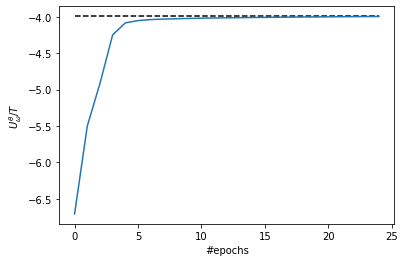

In [11]:
import matplotlib.pyplot as plt

plt.plot(exact/T*np.ones_like(losses), ls = "--", color = "k")
plt.plot(-1*losses/T)
plt.xlabel("#epochs")
plt.ylabel(r"$U_\omega^\theta/T$")
plt.show()